In [72]:
import numpy as np
from numpy import linalg as LA
import math as m
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing default values
import scipy.io as sio
from scipy.optimize import minimize
import timeit
import torch

import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint

In [73]:



def activation_fcn_ReLU(z):
    return np.maximum(0, z)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


#def neuron_mixture_fcn(w,b,x):
#    return b + np.dot(w, x)

#def neuron_fcn(w,b,x):
#    return sigmoid(neuron_mixture_fcn(w,b,x)) #activation_fcn_ReLU(neuron_mixture_fcn(w,b,x))



## Example forward propagation
For the simple neural network example  
![simple nn from Fig 3.5 in Kollmannsberger et al](fig/simple_nn.png "MarineGEO logo")  

Assume $w_{11}^{(1)}=1$, $w_{12}^{(1)}=-3$, $w_{21}^{(1)}=-2$, $w_{22}^{(1)}=1$, $w_{1}^{(2)}=2$, $w_{2}^{(2)}=-1$ and that the activation functions are the sigmoid. Compute the output $\hat{y}$ for $x=[3,2]$. 



In [74]:
W1=np.array([[1.,-3.],[-2.,1.]])
w2=np.array([2.,-1.])
x=np.array([3.,2.])
z1=W1 @ x
a1=sigmoid(z1)
z2= np.dot(w2,a1)
yhat=sigmoid(z2)
print('z2=',z2)
print('output yhat= ',yhat) 

#if we use function
def example1_fcn(x,W1,w2,fcn):
    z1=W1 @ x
    a1=fcn(z1)
    z2= np.dot(w2,a1)
    return fcn(z2)
print('Alternative: yhat=',example1_fcn(x,W1,w2,sigmoid))


z2= 0.076865536393042
output yhat=  0.5192069283210303
Alternative: yhat= 0.5192069283210303


## How is the example network can be built in PyTorch

![simple nn from Fig 3.5 in Kollmannsberger et al](fig/simple_nn.png "MarineGEO logo")  


In [75]:
# Define a custom neural network class named 'MyNet'
class MyNet(nn.Module):
    # Constructor (__init__ method) for initializing the network
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(MyNet, self).__init__()
        # Define the network layers and operations
        # First fully connected layer: 2 input feature, 2 output features
        self.fc1 = nn.Linear(2, 2)
        # Second fully connected layer: 2 input features, 1 output features
        self.fc2 = nn.Linear(2, 1)
        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    # Forward method defines how data flows through the network
    def forward(self, x):
        # Apply sigmoid activation to the first fully connected layer
        x = self.sigmoid(self.fc1(x))
        # Apply sigmoid activation to the second fully connected layer
        x = self.sigmoid(self.fc2(x))
        
        return x

 # Create an instance of the SinNet model
model = MyNet()
# Now we access the model parameters via the model's state_dict
model_state_dict = model.state_dict()
# Get specific parameter values
fc1_weight = model_state_dict['fc1.weight']
fc1_bias = model_state_dict['fc1.bias']
fc2_weight = model_state_dict['fc2.weight']
fc2_bias = model_state_dict['fc2.bias']



x = torch.tensor([3., 2.], dtype=torch.float32)  # Explicitly set the data type to float32
print('x= ',x)
#x = x.view(1, -1) # Ensure that the input has the correct shape
#print('x= ',x)

print('fc1_weight=',fc1_weight)  #weights and biases are set randomized
print('fc1_bias=',fc1_bias)
print('fc2_weight=',fc2_weight)
print('fc2_bias=',fc2_bias)

output = model(x)
print('yhat= ',output)



x=  tensor([3., 2.])
fc1_weight= tensor([[-0.0053,  0.3793],
        [-0.5820, -0.5204]])
fc1_bias= tensor([-0.2723,  0.1896])
fc2_weight= tensor([[-0.0140,  0.5607]])
fc2_bias= tensor([-0.0628])
yhat=  tensor([0.4919], grad_fn=<SigmoidBackward0>)


Assume $w_{11}^{(1)}=1$, $w_{12}^{(1)}=-3$, $w_{21}^{(1)}=-2$, $w_{22}^{(1)}=1$, $w_{1}^{(2)}=2$, $w_{2}^{(2)}=-1$ and that the activation functions are the sigmoid. Compute the output $\hat{y}$ for $x=[3,2]$. 

In [76]:
custom_params = {
    'fc1.weight': torch.tensor([[1.,-3.],[-2.,1.]], dtype=torch.float32),
    'fc1.bias': torch.tensor([0.,0.], dtype=torch.float32),
    'fc2.weight': torch.tensor([[2.,-1.]], dtype=torch.float32),
    'fc2.bias': torch.tensor([0.], dtype=torch.float32),
}

# Set the model's state_dict to the custom parameter values
model.load_state_dict(custom_params)

fc1_weight = model_state_dict['fc1.weight']
fc1_bias = model_state_dict['fc1.bias']
fc2_weight = model_state_dict['fc2.weight']
fc2_bias = model_state_dict['fc2.bias']
print(fc1_weight)
print(fc1_bias)
print(fc2_weight)
print(fc2_bias)


x = torch.tensor([3., 2.], dtype=torch.float32)  # Explicitly set the data type to float32

# Ensure that the input has the correct shape
#x = x.view(1, -1)

print(x)
output = model(x)
print(output)

tensor([[ 1., -3.],
        [-2.,  1.]])
tensor([0., 0.])
tensor([[ 2., -1.]])
tensor([0.])
tensor([3., 2.])
tensor([0.5192], grad_fn=<SigmoidBackward0>)


## Example cost function and gradients
Compute the gradient of the cost function for the neural network (with its parameters) in Problem 1 with $x=[3,2]$ and the target $y=0.3$ by using   
a) Numerical differentiation  
b) automatic differentiation using PyTorch (autograd)

In [77]:
#a)
y=0.3
x=np.array([3.,2.])
C=1/2*(y-example1_fcn(x,W1,w2,sigmoid))**2.
print(C)
#numerical differentiation
dCdW=np.zeros(6)
num_pert=1.e-6

counter=0
for i in range(2):
    for j in range(2):
        W1[i,j]=W1[i,j]+num_pert
        Cdiff=1/2*(y-example1_fcn(x,W1,w2,sigmoid))**2.
        dCdW[counter]=(Cdiff-C)/num_pert
        counter=counter+1
        W1[i,j]=W1[i,j]-num_pert

for i in range(2):
    w2[i]=w2[i]+num_pert
    Cdiff=1/2*(y-example1_fcn(x,W1,w2,sigmoid))**2.
    dCdW[counter]=(Cdiff-C)/num_pert
    counter=counter+1
    w2[i]=w2[i]-num_pert

print(dCdW)

0.024025838711970667
[ 0.01483266  0.00988843 -0.00289956 -0.00193304  0.00259518  0.00098422]


In [78]:

#b)
import torch
x = torch.tensor([3.,2.])
W1=torch.tensor([[1.,-3.],[-2.,1.]], requires_grad=True)   #We want to compute gradient w.r.t. W1
z1=torch.matmul(W1,x)
#Definition of actvation function with torch
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
a1=sigmoid(z1)
print('a1=',a1)
w2=torch.tensor([2.,-1.],requires_grad=True) #We want to compute gradient w.r.t. w2
z2= torch.dot(w2,a1)
C=1./2.*(y-sigmoid(z2))**2. #Computation of cost function
print('C=',C)
# Perform automatic differentiation
C.backward()
# Print the gradients w.r.t. W1 and w2
print(W1.grad)
print(w2.grad)

a1= tensor([0.0474, 0.0180], grad_fn=<MulBackward0>)
C= tensor(0.0240, grad_fn=<MulBackward0>)
tensor([[ 0.0148,  0.0099],
        [-0.0029, -0.0019]])
tensor([0.0026, 0.0010])


## Example NN in PyTorch

Define a NN with three hidden layers and sigmoid as activation function. Assume 10 neurons in each hidden layer.

Allow for different regularization factors and optimization Adam and LBFGS.

In [79]:
#x: input data NumPy 
#y: output data NumPy
#lambda_l1: LASSO regularization parameter
#optim_alg: choice of optimization algorithm 'LBFGS', 'Adam'

def my_nn(x, y, lambda_l1, optim_alg):
    # Convert the data to PyTorch tensors
    x_tensor = torch.from_numpy(x).float().unsqueeze(1)  # Convert input data to PyTorch tensor
    y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # Convert output data to PyTorch tensor

    # Define the neural network model
    class SinNet(nn.Module):
        def __init__(self):
            super(SinNet, self).__init__()
            self.fc1 = nn.Linear(1, 10)  # Fully connected layer 1
            self.fc2 = nn.Linear(10, 10)  # Fully connected layer 2
            self.fc3 = nn.Linear(10, 10)  # Fully connected layer 3
            self.fc4 = nn.Linear(10, 1)  # Fully connected layer 4
            self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

        def forward(self, x):
            x = self.sigmoid(self.fc1(x))  # Apply sigmoid activation to FC1 output
            x = self.sigmoid(self.fc2(x))  # Apply sigmoid activation to FC2 output
            x = self.sigmoid(self.fc3(x))  # Apply sigmoid activation to FC3 output
            x = self.fc4(x)  # Final FC4 layer
            return x

    # Create an instance of the SinNet model
    model = SinNet()

    # Set a random seed for reproducibility, always the same initial guess
    torch.manual_seed(0)

    # Define the loss function
    criterion = nn.MSELoss()  # Mean squared error loss

    # Create a function for closure
    def closure():
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(x_tensor)  # Forward pass through the model
        loss = criterion(outputs, y_tensor)  # Compute mean squared error loss

        # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)  # L1 norm of model parameters

        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization  # Add L1 regularization to the loss
        loss.backward()  # Compute gradients
        return loss

    prev_loss = float('inf')  # Initialize with a large value
    tolerance = 1.e-7
    max_no_epoch = 1000

    if optim_alg == 'LBFGS':
        optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=1000, tolerance_change=tolerance)
    elif optim_alg == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif optim_alg == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    for epoch in range(max_no_epoch):
        def closure_wrapper():
            loss = closure()
            return loss

        loss = optimizer.step(closure_wrapper)  # Optimize model parameters

        # Print the loss every 10th epoch
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}], Loss: {closure().item():.4f}")

        loss_change = prev_loss - loss.item()
        prev_loss = loss.item()

        # Check if the optimizer has converged (you can modify this condition)
        if optim_alg == 'LBFGS':
            if loss_change < tolerance:
                print(f"Optimizer has converged. Stopping training.")
                break

    # Plot the original data and the fitted curve
    plt.scatter(x, y, label='Original Data')
    plt.plot(x, model(x_tensor).detach().numpy(), 'r', label='Fitted Curve')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    return model


## Example NN in PyTorch and Adam optimizer 
Fit data from a noisy $sin$ function by using PyTorch of aneural network with three hidden layers and sigmoid as activation function. Assume 10 neurons in each hidden layer.

Generate noisy data with:

x = np.linspace(0, 2*np.pi, 100)

y = np.sin(x) + np.random.normal(0, 0.1, 100)

Epoch [10], Loss: 0.5259
Epoch [20], Loss: 0.5134
Epoch [30], Loss: 0.4996
Epoch [40], Loss: 0.4731
Epoch [50], Loss: 0.4300
Epoch [60], Loss: 0.3502
Epoch [70], Loss: 0.2309
Epoch [80], Loss: 0.1303
Epoch [90], Loss: 0.1122
Epoch [100], Loss: 0.1079
Epoch [110], Loss: 0.0997
Epoch [120], Loss: 0.0970
Epoch [130], Loss: 0.0942
Epoch [140], Loss: 0.0921
Epoch [150], Loss: 0.0904
Epoch [160], Loss: 0.0889
Epoch [170], Loss: 0.0877
Epoch [180], Loss: 0.0867
Epoch [190], Loss: 0.0858
Epoch [200], Loss: 0.0850
Epoch [210], Loss: 0.0843
Epoch [220], Loss: 0.0837
Epoch [230], Loss: 0.0832
Epoch [240], Loss: 0.0827
Epoch [250], Loss: 0.0824
Epoch [260], Loss: 0.0820
Epoch [270], Loss: 0.0817
Epoch [280], Loss: 0.0815
Epoch [290], Loss: 0.0812
Epoch [300], Loss: 0.0810
Epoch [310], Loss: 0.0808
Epoch [320], Loss: 0.0807
Epoch [330], Loss: 0.0805
Epoch [340], Loss: 0.0804
Epoch [350], Loss: 0.0803
Epoch [360], Loss: 0.0802
Epoch [370], Loss: 0.0801
Epoch [380], Loss: 0.0800
Epoch [390], Loss: 0.

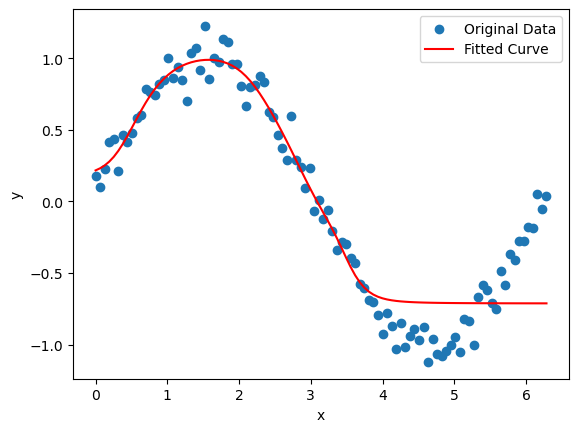

In [80]:
import torch.nn as nn
import torch.optim as optim

# Generate some noisy sine wave data
x = np.linspace(0, 2*np.pi, 100)
np.random.seed(0) # for getting out the same random variables every time (reproducability)
y = np.sin(x) + np.random.normal(0, 0.1, 100)


optim_alg='Adam'  #'LBFGS'
# Define the L1 regularization strength (lambda)
lambda_l1 = 0.0  # You can adjust this value
mymodel=my_nn(x,y,lambda_l1,optim_alg)



## Example NN in PyTorch and LBFGS optimizer 
Fit data from a noisy $sin$ function by using PyTorch of aneural network with three hidden layers and sigmoid as activation function. Assume 10 neurons in each hidden layer.

Generate noisy data with:



Optimizer has converged. Stopping training.


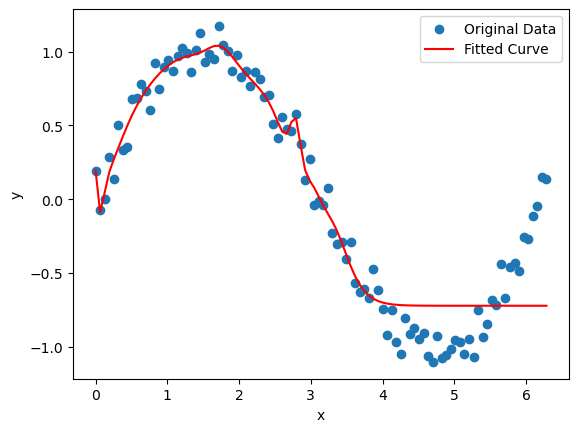

In [81]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)


optim_alg='LBFGS'  #'LBFGS'
# Define the L1 regularization strength (lambda)
lambda_l1 = 0.0  # You can adjust this value
mymodel=my_nn(x,y,lambda_l1,optim_alg)


## Add LASSO regularization
Show that the overfitting is reduced by running the code a number of times.

Optimizer has converged. Stopping training.


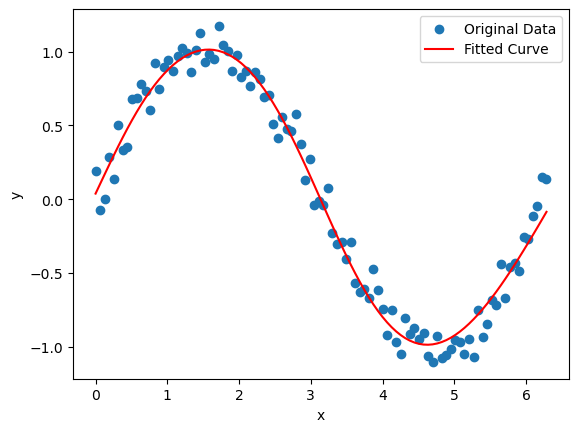

In [82]:
optim_alg='LBFGS'
# Define the L1 regularization strength (lambda)
lambda_l1 = 0.001  # adjust this value
mymodel=my_nn(x,y,lambda_l1,optim_alg)


## Routine for k-fold cross-validation

In [83]:
def train_test_and_k_splits(
    indices,
    test_frac=0.10,          # fraction of data to hold out for the *final test set*
    k=5,                     # number of random validation splits to create
    val_count=None,          # size of each validation set (number of points)
    val_frac=None,           # or fraction of remaining data to use for validation
    seed=42
):
    """
    Split a dataset into:
      1) one fixed test set (held out once and for all)
      2) k random (train, validation) splits from the remaining data

    Parameters
    ----------
    indices : array of int
        All sample indices (e.g., np.arange(n_samples)).
    test_frac : float
        Fraction of total data to hold out as the test set.
    k : int
        Number of random splits to generate from the remaining data.
    val_count : int, optional
        Exact number of validation samples in each split.
    val_frac : float, optional
        Fraction of the *remaining* data to use for validation in each split.
        Used if val_count is not given.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    test_idx : array of int
        Indices belonging to the test set.
    splits : list of (train_idx, val_idx)
        Each element is a tuple with training indices and validation indices.
    """
    rng = np.random.default_rng(seed)
    n = len(indices)

    # --- Step 1: Create a fixed test set (will never be touched again) ---
    n_test = max(1, int(round(n * test_frac)))  # how many samples in the test set
    test_idx = rng.choice(n, size=n_test, replace=False)  # randomly choose test indices
    test_idx.sort()  # sort for readability

    # Remaining data after removing test set
    mask = np.ones(n, dtype=bool)
    mask[test_idx] = False
    remaining = indices[mask]
    n_rem = len(remaining)

    # --- Step 2: Decide how large each validation set should be ---
    if val_count is None:
        if val_frac is None:
            # if user didn’t specify, default to 20% of remaining data
            val_frac = 0.2
        val_count = max(1, int(round(n_rem * val_frac)))

    if val_count >= n_rem:
        raise ValueError("Validation set must be smaller than remaining data.")

    # --- Step 3: Generate k random splits (train/val) from remaining data ---
    splits = []
    for _ in range(k):
        # randomly choose indices for the validation set (within remaining pool)
        val_local_idx = rng.choice(n_rem, size=val_count, replace=False)
        val_local_idx.sort()

        # build the validation indices
        val_idx = remaining[val_local_idx]

        # everything else in 'remaining' goes to the training set
        rem_mask = np.ones(n_rem, dtype=bool)
        rem_mask[val_local_idx] = False
        train_idx = remaining[rem_mask]

        splits.append((train_idx, val_idx))

    return test_idx, splits

    # --- Example usage ---
data_points = np.array([1, 2, 4, 5, 7, 10, 22])
test_idx, splits = train_test_and_k_splits(
    data_points,
    test_frac=0.10,   # 10% test holdout
    k=5,              # create 5 random validation splits
    val_frac=0.2,     # each split: 20% of remaining data for validation
    seed=1            # random seed for reproducibility
)

# --- Inspect results ---
print("Test set size:", len(test_idx))
print("Test indices:", test_idx)

# Loop over the k splits
for i, (train_idx, val_idx) in enumerate(splits, 1):
    print(f"\nSplit {i}")
    print("Train indices:", train_idx)
    print("Validation indices:", val_idx)

Test set size: 1
Test indices: [3]

Split 1
Train indices: [ 1  2  4 10 22]
Validation indices: [7]

Split 2
Train indices: [ 1  2  4  7 22]
Validation indices: [10]

Split 3
Train indices: [ 1  2  4  7 10]
Validation indices: [22]

Split 4
Train indices: [ 2  4  7 10 22]
Validation indices: [1]

Split 5
Train indices: [ 2  4  7 10 22]
Validation indices: [1]


## Modified NN training made for k-fold cross-validation

In [84]:
def my_nn_mod(x, y, train_idx, val_idx, lambda_l1, optim_alg,tolerance,max_no_epoch):

    x_train, y_train = x[train_idx], y[train_idx]
    x_val, y_val = x[val_idx], y[val_idx]

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    x_tensor=torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    
    # Define the neural network model
    class MyNet(nn.Module):
        def __init__(self):
            super(MyNet, self).__init__()
            self.fc1 = nn.Linear(1, 10)  # Fully connected layer 1
            self.fc2 = nn.Linear(10, 10)  # Fully connected layer 2
            self.fc3 = nn.Linear(10, 10)  # Fully connected layer 3
            self.fc4 = nn.Linear(10, 1)  # Fully connected layer 4
            self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

        def forward(self, x):
            x = self.sigmoid(self.fc1(x))  # Apply sigmoid activation to FC1 output
            x = self.sigmoid(self.fc2(x))  # Apply sigmoid activation to FC2 output
            x = self.sigmoid(self.fc3(x))  # Apply sigmoid activation to FC3 output
            x = self.fc4(x)  # Final FC4 layer
            return x

    # Create an instance of the SinNet model
    model = MyNet()

    # Set a random seed for reproducibility, always the same initial guess
    torch.manual_seed(0)

    # Define the loss function
    criterion = nn.MSELoss()  # Mean squared error loss

    # Create a function for closure
    def closure():
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(x_train_tensor)  # Forward pass through the model
        loss = criterion(outputs, y_train_tensor)  # Compute mean squared error loss

        # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)  # L1 norm of model parameters

        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization  # Add L1 regularization to the loss
        loss.backward()  # Compute gradients
        return loss

    prev_loss = float('inf')  # Initialize with a large value

    if optim_alg == 'LBFGS':
        optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=1000, tolerance_change=tolerance)
    elif optim_alg == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif optim_alg == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    train_losses = []  # Store training losses
    val_losses = []   # Store validation losses
    for epoch in range(max_no_epoch):
        def closure_wrapper():
            loss = closure()
            return loss

        loss = optimizer.step(closure_wrapper)  # Optimize model parameters
        # Compute the test loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            train_outputs = model(x_train_tensor)
            train_loss = criterion(train_outputs, y_train_tensor)

        # Store training and test losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Print the loss every 10th epoch
        # Print the loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{max_no_epoch}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

        loss_change = prev_loss - loss.item()
        prev_loss = loss.item()

        # Check if the optimizer has converged (you can modify this condition)
        if loss_change < tolerance:
            print(f"Optimizer has converged. Stopping training.")
            break

    # Plot the original data and the fitted curve
    plt.scatter(x_train_tensor.detach().numpy(), y_train_tensor.detach().numpy(), label='Training data')
    plt.scatter(x_val_tensor.detach().numpy(), y_val_tensor.detach().numpy(), label='Validation data')
    plt.plot(x, model(x_tensor).detach().numpy(), 'r', label='Fitted Curve')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()


    plt.plot(np.arange(len(train_losses)), train_losses, 'b', label='Train loss')
    plt.plot(np.arange(len(val_losses)), val_losses, 'r', label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.legend()
    plt.show()


    return model,train_losses,val_losses

## Example k-fold cross-validation

Optimizer has converged. Stopping training.


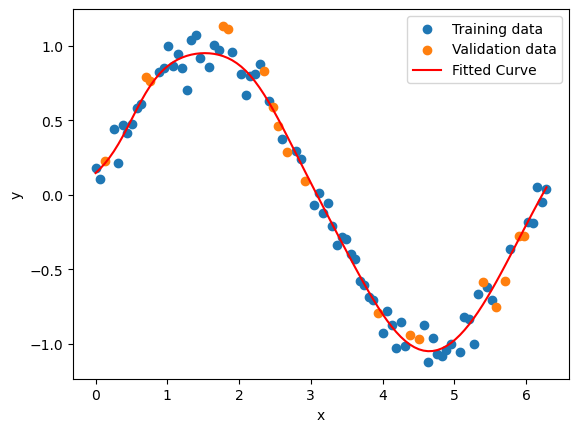

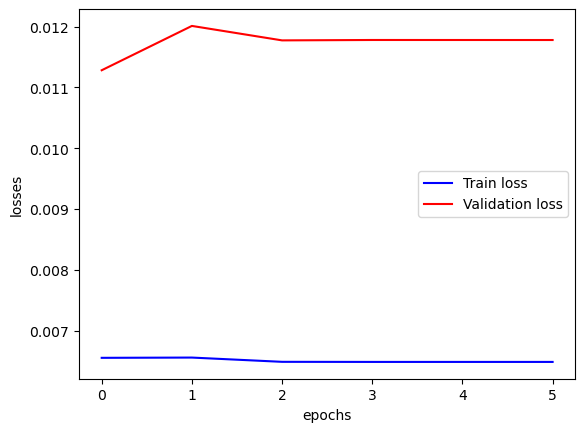

Optimizer has converged. Stopping training.


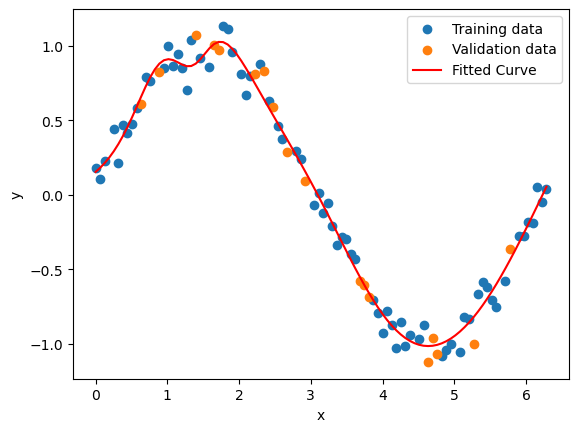

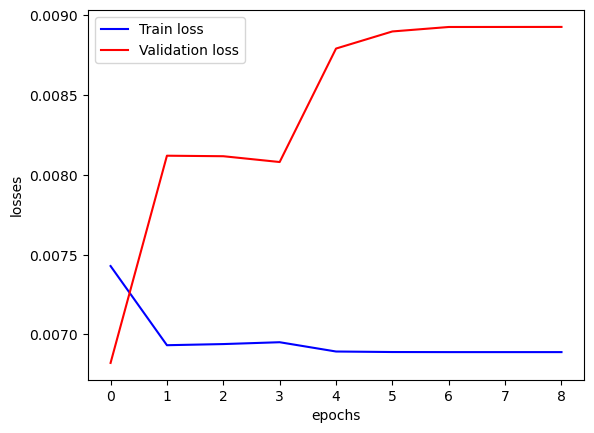

Optimizer has converged. Stopping training.


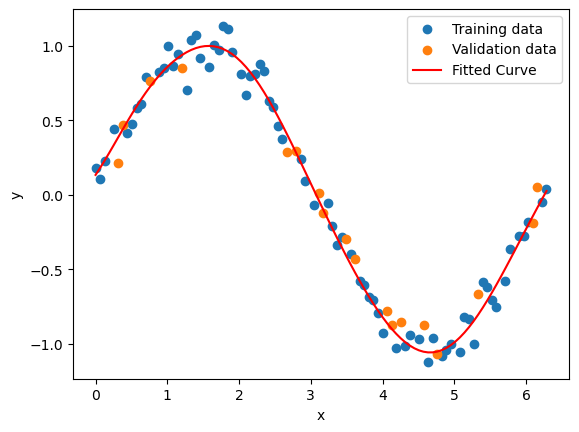

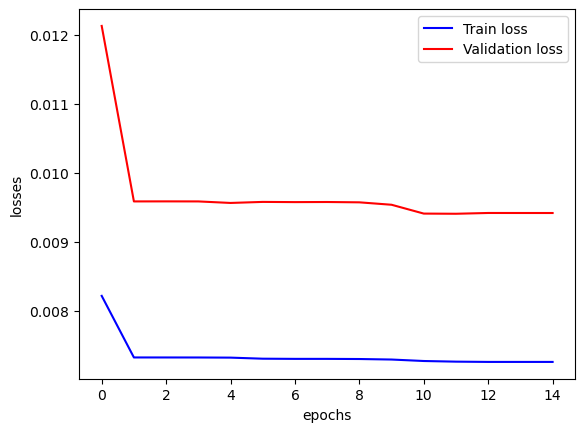

Optimizer has converged. Stopping training.


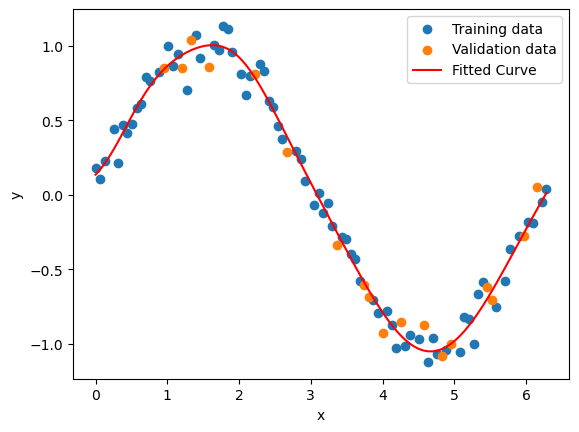

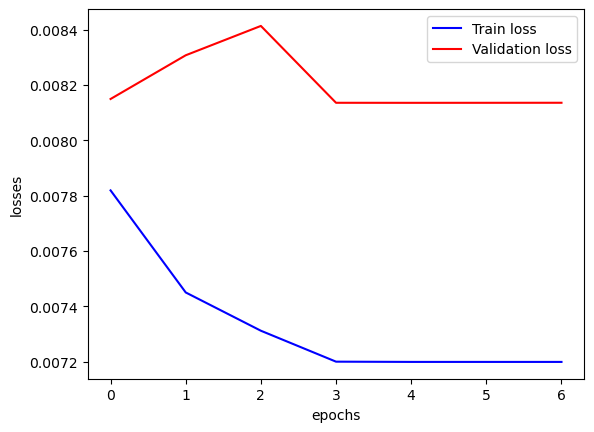

Optimizer has converged. Stopping training.


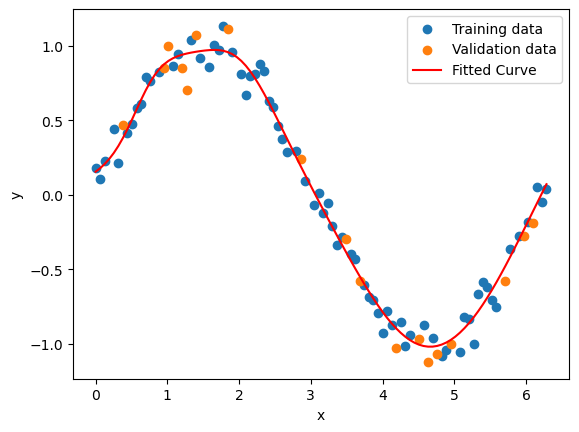

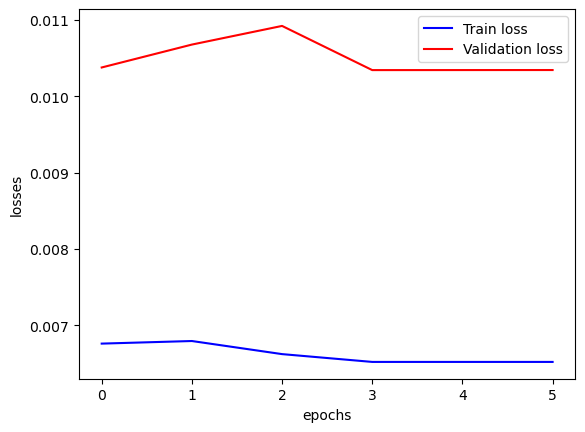

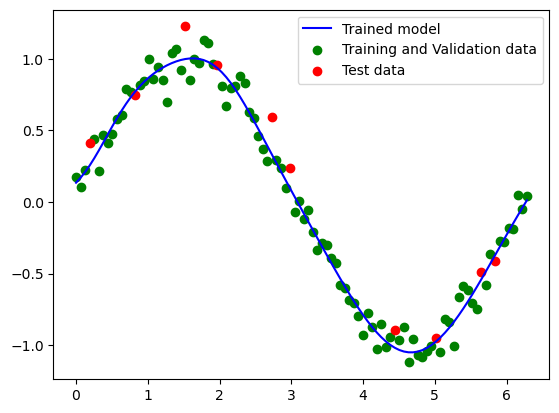

In [85]:
x = np.linspace(0, 2*np.pi, 100)
np.random.seed(0) # for getting out the same random variables every time (reproducability)
y = np.sin(x) + np.random.normal(0, 0.1, len(x))
data_points = np.arange(len(x))


optim_alg='LBFGS' #'Adam'  #'LBFGS' Optimization algorithm
lambda_l1 = 0.00001   # L1 regularization
tolerance = 1.e-7
max_no_epoch = 4000



test_idx, splits = train_test_and_k_splits(
    data_points,
    test_frac=0.1,   # 10% test holdout
    k=5,              # create 5 random validation splits
    val_frac=0.2,     # each split: 20% of remaining data for validation
    seed=1 #for controlling randomness
)

min_val_loss=1.e100 
for i, (train_idx, val_idx) in enumerate(splits, 1):
    x_train, y_train = x[train_idx], y[train_idx]
    x_val, y_val = x[val_idx], y[val_idx]
    mymodel,train_losses,val_losses=my_nn_mod(x,y,train_idx, val_idx,lambda_l1,optim_alg,tolerance,max_no_epoch)
    if val_losses[-1]<min_val_loss:  #save model if validation loss is smallest sofar
        min_val_loss=val_losses[-1]
        best_index=i
        best_model=mymodel


x_tensor=torch.tensor(x, dtype=torch.float32).unsqueeze(1)
plt.plot(x,best_model(x_tensor).detach().numpy(),'b-',label='Trained model')
mask = np.ones(len(x), dtype=bool)   # start with all True
mask[test_idx] = False               # set test indices to False
plt.scatter(x[mask], y[mask], c='g', label='Training and Validation data')
plt.scatter(x[test_idx],y[test_idx],c='r',label='Test data') 
plt.legend()